In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [4]:
def check_season_data(league, season):
    season_dir = f'{league}_{season}'
    data = []
    for sheet in os.listdir(f'data/{season_dir}'):
        temp = pd.read_csv(f'data/{season_dir}/{sheet}').tail(3)
        data.append([sheet.strip('.csv'), temp['W-L'].values[0]])
    df = pd.DataFrame(data, columns=['Team', 'Record'])
    df['W'] = df['Record'].apply(lambda x: x.split('-')[0]).apply(int)
    df['L'] = df['Record'].apply(lambda x: x.split('-')[1]).apply(int)
    df['W%'] = df['W'] / (df['W'] + df['L'])
    return df.sort_values('W%', ascending=False).drop(['W', 'L'], axis=1)

In [5]:
def calculate_pace(team_df):
    temp = team_df.to_dict(orient='records')
    team_records = {'Team': temp[0],
                    'Opponent': temp[1]}
    total_poss = 0
    for side in ['Team']: #, 'Opponent']:
        total_poss += team_records[side]['FGA'] - \
                      team_records[side]['Or'] + \
                      team_records[side]['To'] + \
                      0.44 * team_records[side]['FTA']

    return total_poss, team_records['Team']['MIN'] / 5

In [6]:
def process_team_sheet(team_sheet, season_dir):
    # Initial Process
    df = pd.read_csv(f'data/{season_dir}/{team_sheet}')
    
    shooting_cols = ['2P', '3P', 'FG', 'FT']
    for col in shooting_cols:
        df[f'{col}M'] = df[col].apply(lambda x: x.split('/')[0])\
                               .apply(int)
        df[f'{col}A'] = df[col].apply(lambda x: x.split('/')[1])\
                               .apply(int)
    df.drop(shooting_cols + [col for col in df.columns
                             if '.1' in col], 
            inplace=True, axis=1)
    df['Dr'] = df['Reb'] - df['Or']
    
    # Calculate pace
    team_df = df.tail(3).copy()
    team_poss, team_min = calculate_pace(team_df)
    
    # Get Estimates of players' possessions
    df = df[~df['Height'].isna()]
    df['Poss_est'] = df['MIN'] / team_min * team_poss
    
    return df

In [7]:
def process_season_sheets(season, league):
    season_dir = f'{league}_{season}'
    dfs = [process_team_sheet(team_sheet, season_dir)
           for team_sheet in os.listdir(f'data/{season_dir}/')
           if '.csv' in team_sheet]
    df = pd.concat(dfs).reset_index(drop=True)
    df['season'] = season
    return df

## Process Eurocup

In [8]:
league = 'Eurocup'

In [9]:
seasons = list(range(2018, 2022))

In [10]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2021
# check_season_data(league, 2021)

In [11]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2020
# check_season_data(league, 2020)

In [12]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2019
# check_season_data(league, 2019)

In [13]:
# # https://www.proballers.com/basketball/league/192/eurocup/standings/2018
# check_season_data(league, 2018)

In [10]:
df = pd.concat([process_season_sheets(season, league)
                for season in seasons])\
       .reset_index(drop=True)
df.shape

(1390, 27)

<AxesSubplot: >

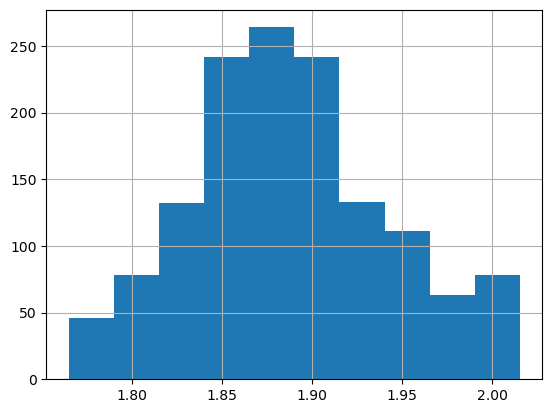

In [11]:
(df['Poss_est'] / df['MIN']).hist()

In [12]:
# df.to_csv('proballers_eurocup_stats.csv', index=False)

In [13]:
# del df

### Merge with Synergy

In [14]:
team_dict = {
    'unicaja-malaga': 'Unicaja Malaga', 
    'tofas-bursa': 'Tofas Bursa', 
    'alba-berlin': 'ALBA Berlin',
    'partizan-mozzart-bet': 'Partizan NiS Beograd', 
    'galatasaray': 'Galatasaray Doga Sigorta', 
    'mornar-bar': 'KK Mornar Bar',
    'dolomiti-energia-trentino': 'Dolomiti Energia Trento', 
    'cedevita-olimpija': 'Cedevita Olimpija Ljubljana',
    'valencia': 'Valencia Basket',
    'morabanc-andorra': 'MoraBanc Andorra', 
    'lokomotiv-kuban': 'Lokomotiv Kuban', 
    'ldlc-asvel': 'LDLC ASVEL Lyon-Villeurbanne', 
    'rytas-vilnius': 'BC Rytas Vilnius', 
    'zenit-st-petersburg': 'Zenit Saint Petersburg', 
    'fraport-skyliners': 'Fraport Skyliners Frankfurt',
    'monaco': 'AS Monaco Basket', 
    'reale-mutua-torino': 'Reale Mutua Torino', 
    'unics-kazan': 'Unics Kazan', 
    'ratiopharm-ulm': 'Ratiopharm Ulm',
    'germani-brescia': 'Germani Brescia Leonessa', 
    'arka-gdynia': 'Asseco Arka Gdynia', 
    'limoges': 'Limoges CSP',
    'turk-telekom': 'Turk Telekom Ankara',
    'crvena-zvezda-mts': 'Crvena Zvezda mts', 
    'ewe-baskets-oldenburg': 'EWE Baskets Oldenburg', 
    'nanterre': 'JSF Nanterre 92',
    'promitheas-patras': 'Promitheas Patras', 
    'maccabi-rishon-lezion': 'Maccabi ILAND.TV Rishon Lezion',
    'umana-reyer-venezia': 'Umana Reyer Venezia', 
    'joventut-badalona': 'Joventut Badalona Club', 
    'darussafaka': 'Darussafaka Tekfen Istanbul',
    'virtus-segafredo-bologna': 'Virtus Segafredo Bologna', 
    'buducnost-voli': 'Buducnost VOLI Podgorica',
    'bahcesehir': 'Bahcesehir Koleji Istanbul',
    'herbalife-gran-canaria': 'Herbalife Gran Canaria', 
    'telenet-giants-antwerp': 'Telenet Giants Antwerp',
    'boulogne-levallois': 'Metropolitans 92', 
    'frutti-extra-bursaspor': 'Frutti Extra Bursaspor Basketbol', 
    'lietkabelis': 'Lietkabelis Panevezys',
    'bourg-en-bresse': 'JL Bourg Basket', 
    'hamburg-towers': 'Hamburg Towers', 
    'wks-slask-wroclaw': 'WKS Slask Wroclaw'
}

In [15]:
proballers_name_dict = {'Abdoulaye Ndoye': 'Abdoulaye NDoye',
                        'Andrey Koscheev': 'Andrey Koshcheev',
                        'Augusto Cesar Lima': 'Augusto Lima',
                        'Can Mutaf': 'Can Maxim Mutaf',
                        'Clinton Chapman': 'Clint Chapman',
                        'Dennis Jerome Seeley': 'D.J. Seeley',
                        'Xabier Lopez-Arosteguj': 'Xabier Lopez-Arostegui',
                        'Demetrius Conger': 'Demitrius Conger',
                        'Deandre Lansdowne': 'DeAndre Lansdowne',
                        'Yunus Sonsirma': 'Yunus Emre Sonsirma',
                        'Evgeniy Kolesnikov': 'Evgeny Kolesnikov',
                        'Mukremin Deniz Kilicli': 'Deniz Kilicli',
                        'Giorgos Bogris': 'Georgios Bogris',
                        'Dmitry Uzinsky': 'Dmitrii Uzinskii',
                        "Jaleel O'Brien": "JJ O'Brien",
                        'Jakarr Sampson': 'JaKarr Sampson',
                        'Ibrahima Faye Fall': 'Ibrahima Fall Faye',
                        "Johnny O'bryant": "Johnny O'Bryant",
                        'Konstantinos Kaimakoglou': 'Kostas Kaimakoglou',
                        'Per Guenther': 'Per Günther',
                        'Roko Leni Ukic': 'Roko Ukic',
                        'Sam Van Rossom': 'Sam van Rossom',
                        'Ignacio Llovet': 'Nacho Llovet',
                        'Kenneth Horton': 'Ken Horton',
                        'Ilia Usoltcev': 'Ilia Usoltsev',
                        'Antonio Crocker': 'Tony Crocker',
                        'Marco Voller': 'Marco Voeller', 
                        'Maximilian DiLeo': 'Max DiLeo',
                        'Stanley Okoye': 'Stan Okoye',
                        'Rafael Martinez': 'Rafa Martinez',
                        'Josep Busquets': 'Pep Busquets',
                        'Efstratios Perperoglou': 'Stratos Perperoglou',
                        'Walerij Lichodiej': 'Valery Likhodey',
                        'Ladontae Henton': 'LaDontae Henton',
                        'Troy Selim Sav': 'Selim Sav',
                        'Vasilis Charalampopoulos': 'Vassilis Charalampopoulos'}

In [16]:
pb_df = pd.read_csv('proballers_eurocup_stats.csv')
pb_df['Season'] = pb_df['season'].apply(lambda x: f'{x}-{x+1}')
pb_df = pb_df.drop('season', axis=1)
pb_df['Team'] = pb_df['Team'].map(team_dict)
pb_df['Player'] = pb_df['Player'].apply(lambda x: proballers_name_dict.get(x, x))
pb_df.head()

,Player,Height,Age,Pts,Reb,Ast,GP,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,Team,2PM,2PA,3PM,3PA,FGM,FGA,FTM,FTA,Dr,Poss_est,Season
0,Giorgi Shermadini,2m16,29.0,237,88,15,19,12-7,343,23,12,31,8,34,288,Unicaja Malaga,89,119,1,2,90,121,56,66,65,642.994277,2018-2019
1,Jaime Fernandez,1m86,25.0,182,39,69,15,10-5,348,10,13,31,2,34,203,Unicaja Malaga,42,75,20,48,62,123,38,48,29,652.367371,2018-2019
2,Mathias Lessort,2m06,23.0,209,102,21,19,12-7,408,33,18,37,25,47,267,Unicaja Malaga,75,107,0,0,75,107,59,98,69,764.844504,2018-2019
3,Kyle Wiltjer,2m08,26.0,195,64,24,19,12-7,362,16,5,19,5,31,178,Unicaja Malaga,43,76,29,86,72,162,22,28,48,678.612035,2018-2019
4,Brian Roberts,1m87,33.0,194,35,75,19,12-7,448,2,16,37,1,48,209,Unicaja Malaga,36,63,27,72,63,135,41,44,33,839.829259,2018-2019


In [17]:
synergy_name_dict = {'AJ Slaughter': 'A.J. Slaughter',
                     'Andrew Crawford': 'Drew Crawford',
                     'Bartolomiej Woloszyn': 'Bartlomiej Woloszyn',
                     'Beqa Burjanadze': 'Beka Burjanadze',
                     'Charalampos Giannopoulos': 'Charis Giannopoulos',
                     'DJ Seeley': 'D.J. Seeley',
                     'Cody Miller-McIntyre': 'Codi Miller-McIntyre',
                     'Codi Miller-Mcintyre': 'Codi Miller-McIntyre',
                     'Daniel Hamiton': 'Daniel Hamilton',
                     'Xabi Lopez-Arostegui': 'Xabier Lopez-Arostegui',
                     'Vladimir Brodzyanski': 'Vladimir Brodziansky',
                     'Dewayne White': 'D.J. White',
                     'Vincent Hunter': 'Vince Hunter',
                     'Trice Travis': 'Travis Trice',
                     'Dave Dudzinski': 'David Dudzinski',
                     'Dmitrik Trice': "D'Mitrik Trice",
                     'Zachary Brown': 'Zach Brown',
                     'Charles Galliou-Loko': 'Charles Galliou',
                     'Terrance Campell': 'T.J. Campbell',
                     'Erol Can Cinko': 'Erol Cinko',
                     'Jeff Whitey': 'Jeff Withey',
                     'James Mcadoo': 'James McAdoo',
                     'Joshua Bostic': 'Josh Bostic', 
                     'Jordan Mcrae': 'Jordan McRae',
                     'Francis Alonso': 'Francisco Alonso',
                     'Ibrahima Faye': 'Ibrahima Fall Faye',
                     'Javier Lopez': 'Javi Lopez',
                     'Jeremy Chappel': 'Jeremy Chappell',
                     'Per Gunther': 'Per Günther',
                     'Gediminas Orelikas': 'Gediminas Orelik',
                     'Hakur Palsson': 'Haukur Palsson',
                     'Göksenin Köksal': 'Goksenin Koksal',
                     'Kenneth Kadji': 'Kenny Kadji', 
                     'Johnathan Hamilton': 'Johnny Hamilton',
                     'Jonathan Hamilton': 'Johnny Hamilton',
                     'Jacorey Williams': 'JaCorey Williams',
                     'Kenny Smith': 'Kenneth Smith',
                     'Martin Meiers': 'Martins Meiers',
                     'Josep Puerto': 'Joseph Puerto',
                     'Rashad James': "Ra'shad James",
                     'Miguel Salvo': 'Miquel Salvo',
                     'Nikos Gikas': 'Nikos Gkikas',
                     'Nikos Rogavopoulos': 'Nikos Rogkavopoulos',
                     'Rachid Sulaimon': 'Rasheed Sulaimon',
                     'Sammy Meija': 'Sammy Mejia',
                     'Marko Jagodic Kuridza': 'Marko Jagodic-Kuridza',
                     'Niels van den Eynde': 'Niels Van Den Eynde',
                     'Omer Can Ilyasoglu': 'Omer Ilyasoglu',
                     'Omer Utku Al': 'Omer Al', 
                     'Sergii Gladyr': 'Sergiy Gladyr',
                     'Thimothe Crusol': 'Timothe Crusol', 
                     'Zahar Vedishchev': 'Zakhar Vedishchev',
                     'Fikret Can Akin': 'Can Akin',
                     'Josep Busquets': 'Pep Busquets',
                     'Artisom Parakhouski': 'Artsiom Parakhouski',
                     'Anthony da Silva': 'Anthony Da Silva',
                     'Lorenzo Dercole': "Lorenzo D'ercole",
                     'Dora Doruk': 'Doruk Dora',
                     'Lapo Giacomo Galli': 'Lapo Galli',
                     'Rafael Santos': 'Rafa Santos',
                     'Owens Josh': 'Josh Owens',
                     'Jean Montero': 'Jean Claudio Montero',
                     'Braian Angola': 'Braian Angola-Rodas',
                     'Valery Kalinov': 'Valeriy Kalinov', 
                     'Thibault Daval Braquet': 'Thibault Daval-Braquet', 
                     'Kirill Yelatontsev': 'Kirill Elatontsev',
                     'Perez Gerardo': 'Gerardo Perez', 
                     'Grantas Vasilauskas': 'Grantas Vasiliauskas'}

In [18]:
synergy_df = pd.read_csv('../data/EuroCup_offense.csv')
synergy_df = synergy_df[synergy_df['Season'] != '2017-2018']\
             .reset_index(drop=True)
synergy_df['Player'] = synergy_df['Player']\
                       .apply(lambda x: x.strip(' ').replace('  ', ' '))\
                       .apply(lambda x: synergy_name_dict.get(x, x))
synergy_df.head()

,Player,Team,Season,GP,FGM,FGA,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt
0,Jalen Reynolds,Zenit Saint Petersburg,2018-2019,16,93.0,161.0,4.0,12.0,0.333333,0.074534,58.0,89.0,0.651685,0.552795,1.0,3.0,0.333333,0.018634,2.0,4.0,0.500000,0.024845,5.0,0.800,0.0,0.000,51.0,0.961,51.0,1.157,14.0,0.786,0.0,0.000,0.0,0.000,29.0,1.310,25.0,1.160,20.0,1.200,195.0,0.025641,0.000000,0.261538,0.261538,0.071795,0.000000,0.000000,0.148718,0.128205,0.102564,0.0,6.0,61.0,0.000000
1,Philip Scrubb,Zenit Saint Petersburg,2018-2019,16,57.0,131.0,20.0,37.0,0.540541,0.282443,20.0,39.0,0.512821,0.297710,28.0,68.0,0.411765,0.519084,16.0,43.0,0.372093,0.328244,16.0,0.750,64.0,0.750,0.0,0.000,0.0,0.000,42.0,1.381,10.0,1.500,7.0,1.571,0.0,0.000,2.0,0.000,30.0,1.033,171.0,0.093567,0.374269,0.000000,0.000000,0.245614,0.058480,0.040936,0.000000,0.011696,0.175439,132.0,18.0,0.0,0.484848
2,Sergey Karasev,Zenit Saint Petersburg,2018-2019,9,48.0,102.0,20.0,43.0,0.465116,0.421569,19.0,29.0,0.655172,0.284314,19.0,45.0,0.422222,0.441176,6.0,21.0,0.285714,0.205882,5.0,1.200,32.0,0.594,1.0,0.000,0.0,0.000,31.0,1.613,27.0,0.926,6.0,0.833,10.0,1.700,3.0,1.333,18.0,1.222,133.0,0.037594,0.240602,0.007519,0.000000,0.233083,0.203008,0.045113,0.075188,0.022556,0.135338,54.0,5.0,1.0,0.592593
3,Evgeny Voronov,Zenit Saint Petersburg,2018-2019,15,39.0,97.0,12.0,33.0,0.363636,0.340206,19.0,33.0,0.575758,0.340206,12.0,40.0,0.300000,0.412371,3.0,17.0,0.176471,0.175258,9.0,0.556,30.0,0.833,4.0,0.500,0.0,0.000,41.0,0.732,5.0,1.000,1.0,0.000,10.0,1.600,9.0,1.000,19.0,1.053,128.0,0.070312,0.234375,0.031250,0.000000,0.320312,0.039062,0.007812,0.078125,0.070312,0.148438,48.0,11.0,5.0,0.625000
4,Marko Simonovic,Zenit Saint Petersburg,2018-2019,15,34.0,92.0,16.0,54.0,0.296296,0.586957,13.0,24.0,0.541667,0.260870,16.0,54.0,0.296296,0.586957,1.0,3.0,0.333333,0.032609,13.0,0.769,1.0,0.000,2.0,0.000,7.0,1.000,43.0,0.744,5.0,1.600,0.0,0.000,3.0,0.667,6.0,1.000,22.0,1.091,102.0,0.127451,0.009804,0.019608,0.068627,0.421569,0.049020,0.000000,0.029412,0.058824,0.215686,1.0,14.0,6.0,1.000000


In [19]:
df = synergy_df.merge(pb_df,
                      on=['Season', 'Team', 'Player'],
                      how='left')

In [20]:
df = df[df['Player'] != 'Sean Evans'].reset_index(drop=True)

In [21]:
df[df['Eff'].isna()]

,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est


## Create New Features

In [22]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']

In [23]:
for situation in situations:
    df[f'{situation}_On_Court%'] = df[f'{situation}_Poss'] / \
                                   df['Poss_est']
    print(situation, 
          df[f'{situation}_On_Court%'].max(),
          df[f'{situation}_On_Court%'].min())
df.head()

Pick and Rolls Including Passes 0.40049482764854966 0.0
Isolations Including Passes 0.26396521367977377 0.0
Post-Ups Including Passes 0.2651555793991416 0.0


,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est,Pick and Rolls Including Passes_On_Court%,Isolations Including Passes_On_Court%,Post-Ups Including Passes_On_Court%
0,Jalen Reynolds,Zenit Saint Petersburg,2018-2019,16,93.0,161.0,4.0,12.0,0.333333,0.074534,58.0,89.0,0.651685,0.552795,1.0,3.0,0.333333,0.018634,2.0,4.0,0.500000,0.024845,5.0,0.800,0.0,0.000,51.0,0.961,51.0,1.157,14.0,0.786,0.0,0.000,0.0,0.000,29.0,1.310,25.0,1.160,20.0,1.200,195.0,0.025641,0.000000,0.261538,0.261538,0.071795,0.000000,0.000000,0.148718,0.128205,0.102564,0.0,6.0,61.0,0.000000,2m07,26.0,221.0,129.0,14.0,16.0,6-10,388.0,40.0,18.0,31.0,13.0,51.0,283.0,94.0,159.0,1.0,3.0,95.0,162.0,30.0,44.0,89.0,740.504732,0.000000,0.008103,0.082376
1,Philip Scrubb,Zenit Saint Petersburg,2018-2019,16,57.0,131.0,20.0,37.0,0.540541,0.282443,20.0,39.0,0.512821,0.297710,28.0,68.0,0.411765,0.519084,16.0,43.0,0.372093,0.328244,16.0,0.750,64.0,0.750,0.0,0.000,0.0,0.000,42.0,1.381,10.0,1.500,7.0,1.571,0.0,0.000,2.0,0.000,30.0,1.033,171.0,0.093567,0.374269,0.000000,0.000000,0.245614,0.058480,0.040936,0.000000,0.011696,0.175439,132.0,18.0,0.0,0.484848,1m92,26.0,187.0,41.0,49.0,16.0,6-10,418.0,6.0,19.0,27.0,1.0,25.0,184.0,30.0,64.0,28.0,68.0,58.0,132.0,43.0,55.0,35.0,797.760252,0.165463,0.022563,0.000000
2,Sergey Karasev,Zenit Saint Petersburg,2018-2019,9,48.0,102.0,20.0,43.0,0.465116,0.421569,19.0,29.0,0.655172,0.284314,19.0,45.0,0.422222,0.441176,6.0,21.0,0.285714,0.205882,5.0,1.200,32.0,0.594,1.0,0.000,0.0,0.000,31.0,1.613,27.0,0.926,6.0,0.833,10.0,1.700,3.0,1.333,18.0,1.222,133.0,0.037594,0.240602,0.007519,0.000000,0.233083,0.203008,0.045113,0.075188,0.022556,0.135338,54.0,5.0,1.0,0.592593,2m00,25.0,151.0,27.0,27.0,9.0,4-5,243.0,5.0,3.0,17.0,1.0,25.0,137.0,30.0,58.0,19.0,45.0,49.0,103.0,34.0,35.0,22.0,463.769716,0.116437,0.010781,0.002156
3,Evgeny Voronov,Zenit Saint Petersburg,2018-2019,15,39.0,97.0,12.0,33.0,0.363636,0.340206,19.0,33.0,0.575758,0.340206,12.0,40.0,0.300000,0.412371,3.0,17.0,0.176471,0.175258,9.0,0.556,30.0,0.833,4.0,0.500,0.0,0.000,41.0,0.732,5.0,1.000,1.0,0.000,10.0,1.600,9.0,1.000,19.0,1.053,128.0,0.070312,0.234375,0.031250,0.000000,0.320312,0.039062,0.007812,0.078125,0.070312,0.148438,48.0,11.0,5.0,0.625000,1m96,32.0,116.0,36.0,27.0,15.0,6-9,363.0,14.0,9.0,23.0,2.0,52.0,100.0,27.0,58.0,12.0,40.0,39.0,98.0,26.0,34.0,22.0,692.791798,0.069285,0.015878,0.007217
4,Marko Simonovic,Zenit Saint Petersburg,2018-2019,15,34.0,92.0,16.0,54.0,0.296296,0.586957,13.0,24.0,0.541667,0.260870,16.0,54.0,0.296296,0.586957,1.0,3.0,0.333333,0.032609,13.0,0.769,1.0,0.000,2.0,0.000,7.0,1.000,43.0,0.744,5.0,1.600,0.0,0.000,3.0,0.667,6.0,1.000,22.0,1.091,102.0,0.127451,0.009804,0.019608,0.068627,0.421569,0.049020,0.000000,0.029412,0.058824,0.215686,1.0,14.0,6.0,1.000000,2m03,32.0,90.0,39.0,14.0,15.0,6-9,264.0,12.0,9.0,13.0,2.0,17.0,78.0,18.0,38.0,16.0,54.0,34.0,92.0,6.0,11.0,27.0,503.848580,0.001985,0.0

## Save

In [24]:
df.to_csv('../eurocup_offense_plus_pb.csv', index=False)